In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/permanent/RECHERCHE3
%ls

/gdrive/My Drive/permanent/RECHERCHE3
ddqn_lib/  Euler.zip  model_1.h5  popup_lib/
Euler/     Hamilton/  model_2.h5  popup_lib.zip


In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Hamilton.separable.data_gen import Param,solver_symplectic_separable
import Hamilton.separable.preprocessing as prepro
from Hamilton.separable.agent import Agent

# Différents k-tests

In [ ]:
def test_ktest(config,external_recall,distrib_on_q):

    param=Param(config,
                nb_particle=4,
                nb_t=3000,
                external_recall=external_recall,
                distrib_on_q=distrib_on_q)
    
    q0= tf.linspace(0.1,0.5,param.nb_particle)[tf.newaxis,:]    
    p0=tf.zeros([1,param.nb_particle])

    qs,ps=solver_symplectic_separable(nb_t, param.dt, q0, p0, param.dH1, param.dH2)

    print("qs.shape:",qs.shape)
    print("ps.shape:",ps.shape)

    fig, (ax0,ax1) = plt.subplots(1,2 ,figsize=(8,4),sharey="all")

    fig.suptitle(config)
    for i in range(ps.shape[1]):
        ax0.plot(qs[:,i],ps[:,i])
        ax1.plot(qs[:300,i],ps[:300,i])
        ax0.set_xlabel("q")
        ax0.set_ylabel("p")
        #ax0.set_aspect("equal")
        #ax1.set_aspect("equal")

In [ ]:
def all_config(external_recall,distrib_on_q):
    for config in [Param.config_independant,Param.config_mean_recall,Param.config_attractive_particles,Param.config_sinus_perturb]:
        test_ktest(config,external_recall,distrib_on_q)

## les q sont distributés, les p sont nuls

qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)


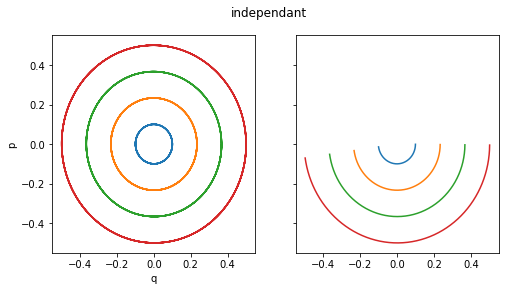

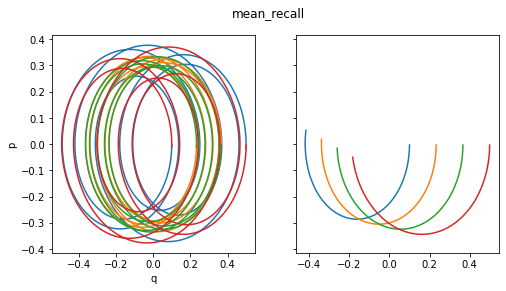

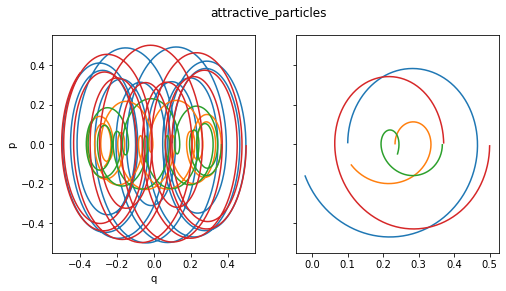

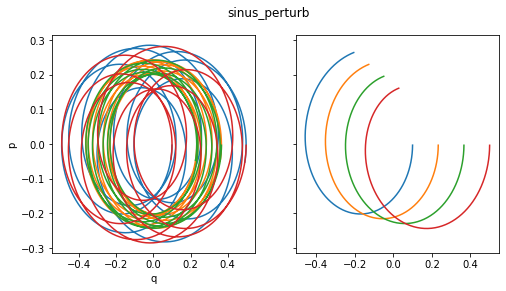

In [ ]:
all_config(0.1,True)

qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)


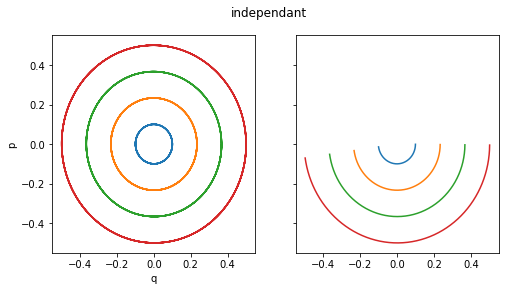

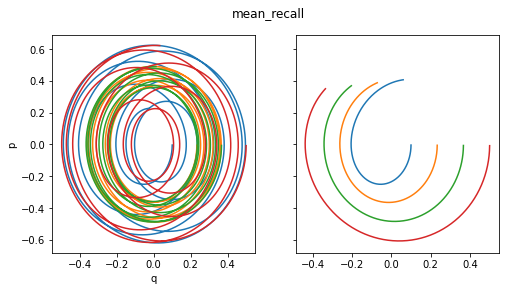

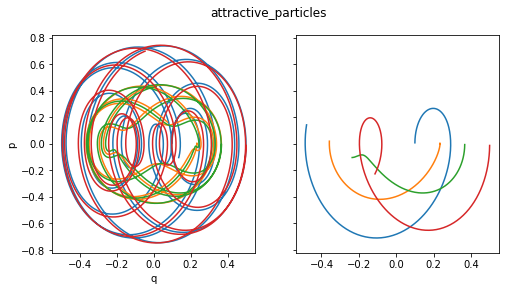

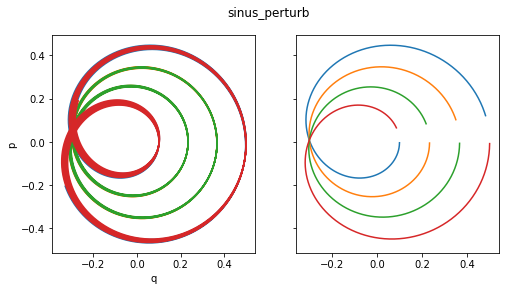

In [ ]:
all_config(1,True)

## les q sont nuls, les p sont distribués

qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)


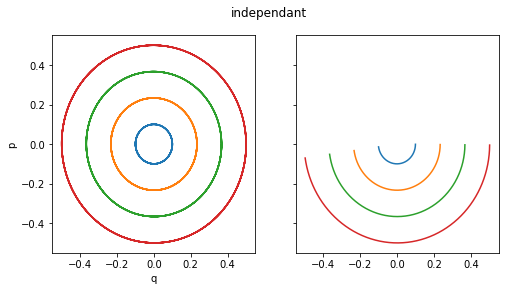

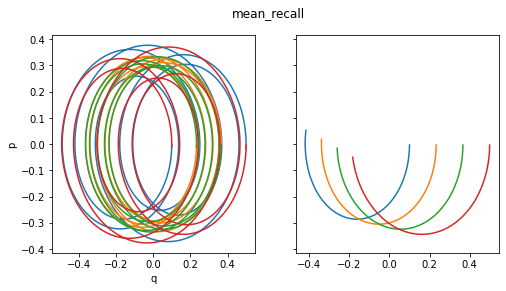

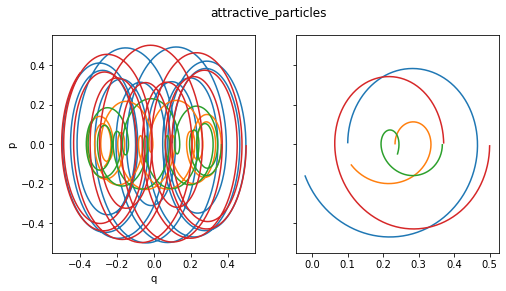

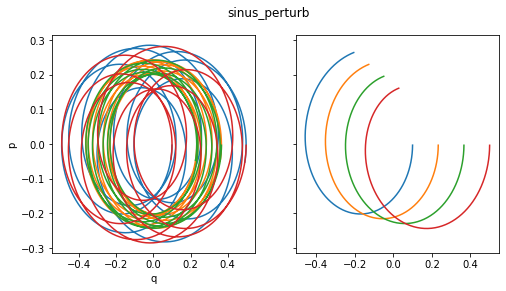

In [ ]:
all_config(0.1,False)

qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)
qs.shape: (3000, 1, 4)
ps.shape: (3000, 1, 4)


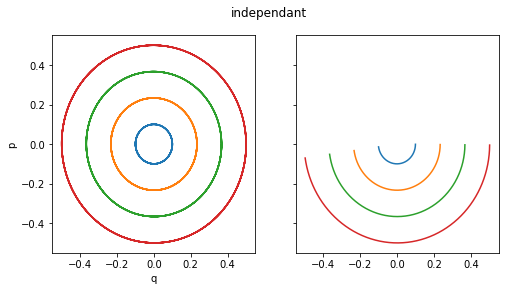

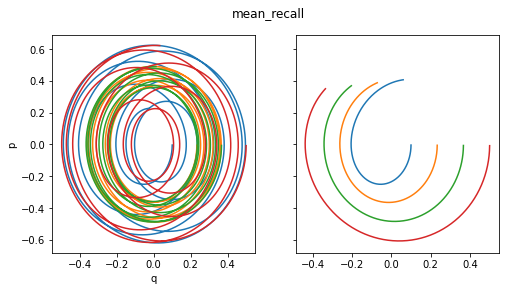

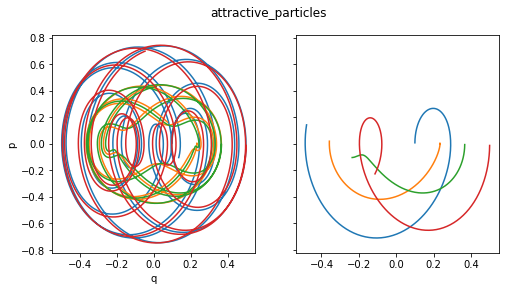

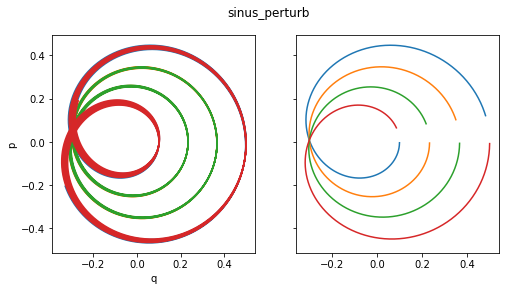

In [ ]:
all_config(1,False)

# Les différentes options

## Utiliser un modèle ou deux

cas  général: `H(q,p)` est quelconque

Le schéma symplectique est implicite

        q_n+1= q_n + dt d/dp H(q_n+1,p_n)
        p_n+1= p_n - dt d/dq H(q_n+1,p_n)

-------------------------------------

cas dynamique séparable: H est de la forme

        H(q,p) = H1(q) + H1(p)
        d/dp H(q,p) = dH2(p) 
        d/dq H(q,p) = dH1(q)

Le schéma symplectique est explicite

        q_n+1= q_n + dt dH2(p_n)
        p_n+1= p_n - dt dH1(q_n+1)

---------------------------------------

cas mécanique classique

        H(q,p) = H1(q) + p^2/2 
        d/dp H(q,p) = p 
        d/dq H(q,p) = dH1(q_n+1)

Le schéma symplectique est explicite

        q_n+1= q_n + dt p_n
        p_n+1= p_n - dt dH1(q_n+1)

Le cas général n'est pas implémenté. 

Comparons les cas séparable et mécanique classique.

* Pour le cas séparable il faut 2 modèles, il faut donc utiliser l'option (par défaut) `use_a_second_model=True`. 

* Pour le cas 'mécanique classique' un seul modèle suffit, donc `use_a_second_model=False` C'est donc plus rapide, mais moins général. Cela marchera sans doute beaucoup moins bien sur la config `sinus_perturb` dont le `dH2(p)` n'est pas égal à `p` 








## Apprendre  H ou son gradient

L'agent créer un multi-layer-perceptrons `model_1` 



* Avec l'option `learn_directly_dH = True` on a `dH1(q) = model_1(q)`. Attention, dans ce cas on n'est pas forcément dans le cas "Hamiltonien" classique, car toute fonction générique de R^n dans R^n n'est pas forcément le gradient d'une fonction de R^n dans R 


* Avec l'option `learn_directly_dH = False` on a `H1(q) = model_1(q)`. On optient avec `dH1` avec le gradient tape de tensorflow. C'est plus lent. 

---
`use_a_second_model = True` la même chose a lieu avec `model_2` et `H2`



## corriger les modèles via le schéma symplectique

La technique utilisé pendant de projet M2, c'est:

        with tf.GradientTape(persistent=True) as tape:
            dq_pred=self.dH2(p)
            dp_pred=-self.dH1(q)
            loss=tf.reduce_mean((dq_true-dq_pred)**2 + (dp_true-dp_pred)**2 )


où les `dq_true` et `dq_pred` sont calculés par différences :

        dq= (q[1:] - q[:-1]) /dt
        dp= (p[1:] - p[:-1]) / dt

Astuce (bien, pas bien ?). Si on veut respecter le schema symplectique:

                    (q^n+1-q^n)/dt= dH2(p^n)
                    (p^n+1-p^n)/dt= dH1(q^n+1)

du coup c'est un q décallé qu'il faut donner à manger à dH1. 

---

Nouvelle technique proposée (celle utilisé dans le projet Euler). On fait tourner le schema symplectique à l'intérieur du Gradient Tape: 

        with tf.GradientTape(persistent=True) as tape:

            for _ in tf.range(watch_duration):
                q_n_1= q_n + dt * self.dH2(p_n)
                p_n_1= p_n - dt * self.dH1(q_n_1)
                q_n=q_n_1
                p_n=p_n_1

            loss=tf.reduce_mean((q_n_1-q_final)**2 + (p_n_1-p_final)**2 )


# Comparatifs

In [ ]:
NB_PARTICLE=12

In [ ]:
def test_agent_options(config,distrib_on_q=True):

    param=Param(config=config,nb_particle=NB_PARTICLE,distrib_on_q=distrib_on_q)
    lines=[]
    for use_a_second_model in [True,False]:
        for learn_directly_dH in [True,False]:
            for watch_duration in [None,1,2]:
                line={}
                lines.append(line)
                agent=Agent(param,
                            use_a_second_model=use_a_second_model,
                            learn_directly_dH=learn_directly_dH,
                            watch_duration=watch_duration
                            )
                error,(q_pred,p_pred),(q_true,p_true)=agent.train(0.2)
                
                line["error"]=error
                line["use_a_second_model"]=use_a_second_model
                line["learn_directly_dH"]=learn_directly_dH
                line["watch_duration"]=watch_duration
                line["qp_pred"]=(q_pred,p_pred)
                line["qp_true"]=(q_true,p_true)

    compar = pd.DataFrame(lines)
    compar=compar.sort_values(by=['error'])

    
    return compar

In [ ]:
def show_the_best(compar):
    best=compar.iloc[0]
    (q_pred,p_pred)=best["qp_pred"]
    (q_true,p_true)=best["qp_true"]

    fig, axs = plt.subplots(2,2,figsize=(10,10),sharex="all",sharey="all")

    print(q_pred.shape)
    short=100
    for i in range(NB_PARTICLES):
        axs[0,0].plot(q_pred[:,0, i], p_pred[:,0, i])
        axs[0,1].plot(q_pred[:short,0, i], p_pred[:short,0, i])

        axs[0,0].set_title("pred")
        axs[1,0].plot(q_true[:, 0, i], p_true[:, 0, i])
        axs[1,1].plot(q_true[:short, 0, i], p_true[:short, 0, i])
        axs[1,0].set_title("true")

### `config_attractive_particles`

In [ ]:
config=Param.config_attractive_particles
compar_attractive_particles=test_agent_options(config)
compar_attractive_particles


Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:21.7596⤥:13.5146⤥:7.0458⤥:2.8781⤥:0.9390..⤥:0.3255...⤥:0.1133......⤥:0.0995.⤥:0.0792.............
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:35.5867⤥:33.4368.⤥:9.5857⤥:8.8336⤥:2.2289⤥:1.8456⤥:1.3578....⤥:0.8786......⤥:0.2954............⤥:0.0464
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:2,preprocess_fn:None
⤥:36.0770.⤥:4.9002⤥:3.3548⤥:2.5863.⤥:0.5657......⤥:0.1355...⤥:0.1193.....⤥:0.0834....⤥:0.0709.
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:57.2991.⤥:31.0239⤥:28.4572....⤥:13.4888⤥:10.3506....⤥:8.9468..⤥:8.7152....⤥:4.1668⤥:1.4238⤥:1.3559
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:42.3396.⤥:25.4547⤥:23.7030..............⤥:21.1017⤥:14.9416⤥:14.0343
Agent with: learn_directly_dH:False, us

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
2,0.037113,True,True,2.0,(((tf.Tensor(\n[0.02999359 0.06816075 0.106320...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
0,0.148842,True,True,NaN,(((tf.Tensor(\n[0.03002848 0.06819982 0.106356...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
6,0.303143,False,True,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
8,0.364139,False,True,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
7,0.457211,False,True,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
9,0.550239,False,False,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
3,0.820827,True,False,NaN,(((tf.Tensor(\n[0.03002892 0.06819335 0.106274...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
10,0.825052,False,False,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
11,1.394148,False,False,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
1,1.407079,True,True,1.0,(((tf.Tensor(\n[0.02999316 0.06817911 0.106361...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


(1000, 1, 12)


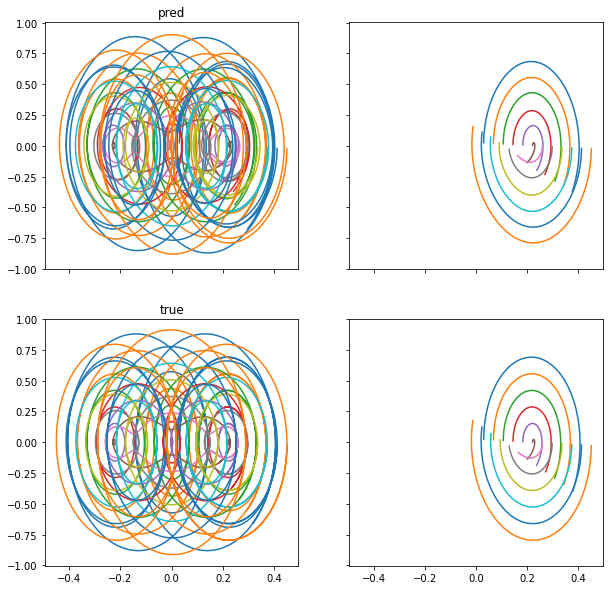

In [ ]:
show_the_best(compar_attractive_particles)

### `config_mean_recall`

In [ ]:
compar_mean_recall=test_agent_options(Param.config_mean_recall)
compar_mean_recall


Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:1.4741⤥:0.6861⤥:0.0335⤥:0.0161⤥:0.0065.⤥:0.0048⤥:0.0048⤥:0.0046.⤥:0.0022.............⤥:0.0011..........
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:18.3070.⤥:7.6070⤥:6.9090⤥:6.5456⤥:5.6131⤥:4.6492⤥:3.1386⤥:1.9735⤥:1.2969⤥:0.7557⤥:0.5468⤥:0.2708⤥:0.1624⤥:0.0940⤥:0.0568⤥:0.0399⤥:0.0224⤥:0.0210⤥:0.0191⤥:0.0178⤥:0.0125.⤥:0.0111......⤥:0.0081
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:2,preprocess_fn:None
⤥:22.9063⤥:10.6584⤥:4.4911⤥:1.4141⤥:0.2433⤥:0.0517⤥:0.0124.⤥:0.0063..⤥:0.0048⤥:0.0031..........⤥:0.0020.....
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:20.4453⤥:15.7562.⤥:15.5611⤥:7.7609⤥:4.8224⤥:4.5719⤥:3.6633⤥:3.5742...⤥:0.1163.⤥:0.0563⤥:0.0243.....⤥:0.0123⤥:0.0113...
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:1,

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
0,0.004474,True,True,NaN,(((tf.Tensor(\n[0.02999169 0.06816179 0.106357...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
7,0.006965,False,True,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
8,0.008318,False,True,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
1,0.008553,True,True,1.0,(((tf.Tensor(\n[0.02999851 0.06817815 0.106357...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
3,0.012327,True,False,NaN,(((tf.Tensor(\n[0.02998768 0.06820062 0.106381...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
2,0.016483,True,True,2.0,(((tf.Tensor(\n[0.0299953 0.06817873 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
11,0.020928,False,False,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
6,0.028911,False,True,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
9,0.032577,False,False,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
10,2.092921,False,False,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


(1000, 1, 12)


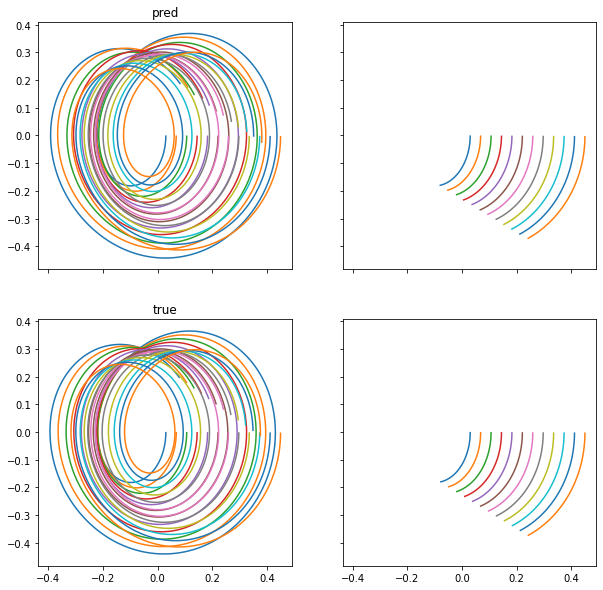

In [ ]:
show_the_best(compar_mean_recall)

### `config_sinus_perturb`

In [ ]:
compar_sinus_perturb=test_agent_options(Param.config_sinus_perturb)
compar_sinus_perturb


Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:5.6396⤥:1.7084⤥:0.0646⤥:0.0228⤥:0.0182.⤥:0.0069⤥:0.0060...⤥:0.0056.⤥:0.0042.⤥:0.0039..⤥:0.0034.⤥:0.0022.....⤥:0.0022.....
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:15.2943⤥:13.0706⤥:5.7044.⤥:4.4314⤥:3.9247⤥:2.8656⤥:2.1929⤥:1.3496⤥:0.9649⤥:0.4573⤥:0.2646⤥:0.1549⤥:0.0808⤥:0.0436⤥:0.0308⤥:0.0255⤥:0.0164⤥:0.0139⤥:0.0106.⤥:0.0087⤥:0.0084..⤥:0.0065....
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:2,preprocess_fn:None
⤥:15.5381⤥:14.4715⤥:5.6017⤥:1.8379⤥:0.3341⤥:0.0815⤥:0.0169⤥:0.0168⤥:0.0065.⤥:0.0059..........⤥:0.0042......⤥:0.0033
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:20.2037⤥:11.6708..⤥:4.0389.⤥:2.4391......⤥:0.4781⤥:0.1455⤥:0.1296⤥:0.0462⤥:0.0362..⤥:0.0359⤥:0.0183...
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
2,0.006366,True,True,2.0,(((tf.Tensor(\n[0.03001474 0.06819863 0.106379...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
1,0.007519,True,True,1.0,(((tf.Tensor(\n[0.03000419 0.06818648 0.106368...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
0,0.009898,True,True,NaN,(((tf.Tensor(\n[0.02998685 0.06817213 0.106347...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
3,0.018562,True,False,NaN,(((tf.Tensor(\n[0.03003907 0.06820991 0.106397...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
5,4.817257,True,False,2.0,(((tf.Tensor(\n[0.03009811 0.06831276 0.106452...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
4,13.446106,True,False,1.0,(((tf.Tensor(\n[0.03016095 0.06830627 0.106458...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
11,14.309326,False,False,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
9,14.364445,False,False,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
8,14.447875,False,True,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
7,14.503983,False,True,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


(1000, 1, 12)


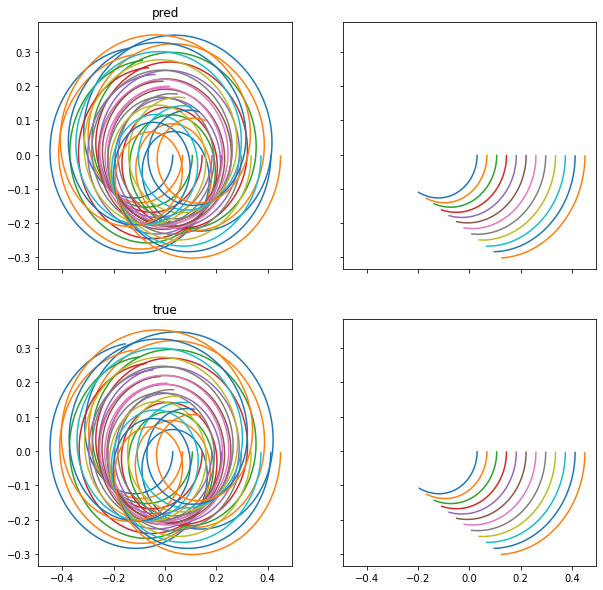

In [ ]:
show_the_best(compar_sinus_perturb)

### `config_independant`

In [ ]:
compar_independant=test_agent_options(Param.config_independant)
compar_independant


Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:5.9250⤥:0.3016⤥:0.2025⤥:0.0289⤥:0.0182⤥:0.0147⤥:0.0133.⤥:0.0080⤥:0.0071⤥:0.0055⤥:0.0035...⤥:0.0029⤥:0.0023..⤥:0.0016⤥:0.0013...⤥:0.0012...........
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:18.2458.⤥:2.0883⤥:0.4524⤥:0.1600⤥:0.0965⤥:0.0861..⤥:0.0824.......⤥:0.0643..........⤥:0.0585.......
Agent with: learn_directly_dH:True, use_a_second_model:True,watch_duration:2,preprocess_fn:None
⤥:4.8587⤥:1.7064⤥:0.5631⤥:0.1611.⤥:0.1498⤥:0.1238..⤥:0.1012⤥:0.0910.⤥:0.0788.......⤥:0.0741.⤥:0.0524..⤥:0.0506⤥:0.0473⤥:0.0357⤥:0.0300⤥:0.0299⤥:0.0264
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:None,preprocess_fn:None
⤥:14.8144.⤥:12.4133.⤥:4.7644⤥:0.4215⤥:0.2933⤥:0.0927.⤥:0.0762.⤥:0.0745⤥:0.0545.....⤥:0.0530.⤥:0.0424......
Agent with: learn_directly_dH:False, use_a_second_model:True,watch_duration:1,preprocess_fn:None
⤥:1

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
6,0.000248,False,True,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
8,0.001780,False,True,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
0,0.002670,True,True,NaN,(((tf.Tensor(\n[0.0300027 0.06818912 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
2,0.003068,True,True,2.0,(((tf.Tensor(\n[0.03000185 0.06818503 0.106368...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
1,0.005960,True,True,1.0,(((tf.Tensor(\n[0.03000741 0.06818774 0.106366...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
11,0.009719,False,False,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
7,0.009883,False,True,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
9,0.013886,False,False,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
3,0.021642,True,False,NaN,(((tf.Tensor(\n[0.02998226 0.06816846 0.106352...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
5,0.049929,True,False,2.0,(((tf.Tensor(\n[0.03011116 0.06835248 0.106505...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


(1000, 1, 12)


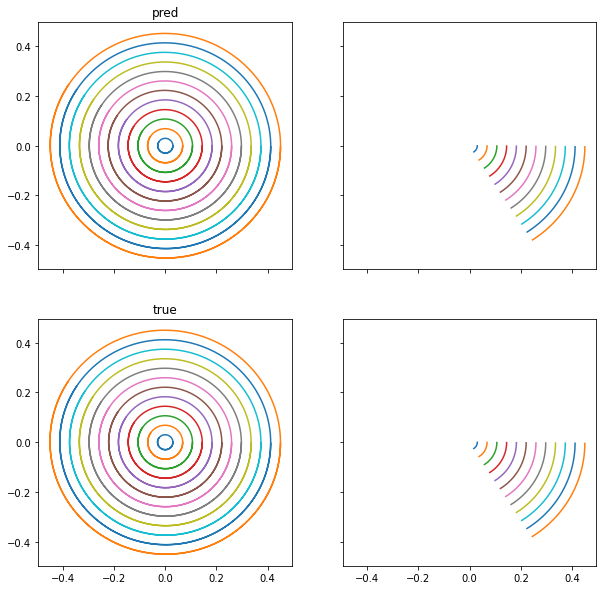

In [ ]:
show_the_best(compar_independant)

### All the best

In [ ]:
def compare_best(index):
    all=[
        compar_attractive_particles.iloc[index],
        compar_mean_recall.iloc[index],
        compar_sinus_perturb.iloc[index],
        compar_independant.iloc[index]
    ]
    all_df=pd.DataFrame(all,index=["attractive_particles","mean_recall","sinus_perturb","independant"])
    return all_df

In [ ]:
compare_best(0)

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
attractive_particles,0.037113,True,True,2.0,(((tf.Tensor(\n[0.02999359 0.06816075 0.106320...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
mean_recall,0.004474,True,True,NaN,(((tf.Tensor(\n[0.02999169 0.06816179 0.106357...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
sinus_perturb,0.006366,True,True,2.0,(((tf.Tensor(\n[0.03001474 0.06819863 0.106379...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
independant,0.000248,False,True,NaN,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


In [ ]:
compare_best(1)

,error,use_a_second_model,learn_directly_dH,watch_duration,qp_pred,qp_true
attractive_particles,0.148842,True,True,NaN,(((tf.Tensor(\n[0.03002848 0.06819982 0.106356...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
mean_recall,0.006965,False,True,1.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
sinus_perturb,0.007519,True,True,1.0,(((tf.Tensor(\n[0.03000419 0.06818648 0.106368...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...
independant,0.001780,False,True,2.0,(((tf.Tensor(\n[0.03 0.06818181 0.106363...,(((tf.Tensor(\n[0.03 0.06818181 0.106363...


Conclusion: 

* `learn_directly_dH=True` est toujours la meilleurs option. Il faudrait cependant tester avec différentes architecture de réseau de neurone. L'inconvénient de cette option, c'est qu'on n'a pas construit la fonction `H` explicitement; mais en a-t-on vraiment besoin ? 

* `use_a_second_model=True` est aussi à privilégier: L'option `False` apparait 
    * en premier uniquement dans le cas hyper-simple `independant`
    * en second uniquement dans le cas très simple `mean-recall`
    * moralement c'est une option qui donne plus de liberté à l'apprentissage? 


* Utiliser la `watch_duration` semble aussi profitable: 
    * Pour les `attractive_particles` elle améliore l'erreur de `0.14` à `0.03`
    * Pour `mean_recall` elle détériore l'erreur mais seulement de `0.004` à `0.006`
    * Pour `independant` elle est néfaste, mais c'est un cas très particulier. 
    * On peut imaginer que `watch_duration` amériore l'apprentissage des phénomènes complexes. Il faudrait ensuite voir quelle est sa valeur optimale (pour le projet Euler on va jusqu'à 50 !)







## Discution

### Le pipeline

Le pipeline du projet Hamilton: 

                                   dH1
                                   ---> R^k
              sample     Enc                 Dec       mean
    Proba(R^2) ---> R^2n ---> R^2k           ---> R^2n ---> Proba(R^2)
                                   dH2
                                   ---> R^k

    rhoV_t -------> QP_t ---> qp_t  ---> qp_t+1--> QP_t+1--> rhoV_t+1


Remarque: 
* les applications `Enc` et `Dec` sont séparable.

        Enc(q,p) = Enc1(q) , Enc2(p)

* Les deux applications `dH1` et `dH2` peuvent être les gradients de fonction `H1` et `H2`. Les expériences précédentes montre que cela marche moins bien (à vérifier sur des cas plus complexe). 

---

On a 2 loss: 

1. Le fait que `Enc o Dec` doit être l'identité. 


2. La distance entre le résulat `QP_t+1` obtenu par l'encodate + le schéma symplectique en dim-réduite,  et l'équivalent obtenu sans utiliser la réduction de dimension = la solution de référence.  

---

En phase d'exploitation (test), on donne en entrée uniquement `QP_0` et on laisse tourner le schéma symplectique en dimension réduite. 


Mais en phase train, on peut aussi s'inspirer de cela: faire tourner le schéma symplectique sur plusieurs pas de temps avant de comparer le résultat à la solution de référence. C'est la technique utilisée quand on précise une `watch_duration`. 










### Apprendre l'interpolation


On pourrait inclure l'opération 

           mean
        QP ---> rhoV

Il s'agit d'une opération de lissage qui peut classiquement s'apprendre avec des réseaux convolutif. 


On pourrait aussi apprend directement

            Dec    mean
        qp ---> QP ---> rhoV

en ajoutant une loss pour qu'elle soit l'inverse de 

            sample    Enc 
       rhoV -----> QP ----> qp



    



### Espace temps

On pourrait faire des apprentissages en espace temps: passez des séquences complétes `QP_{0,1,2,...t}` dans des réseaux spaciaux temporels de type `CNN` ou `RNN`

### Sur la symétries

Les particules sont échangeables. Ainsi l'Hamiltonien initial vérifie que, pour toute permutation $\sigma$: 
$$
H(q_1,q_2,...; p_1,p_2,...) = H(q_{\sigma(1)},q_{\sigma(2)},...; p_{\sigma(1)},p_{\sigma(2)},...) 
$$

Pourrait-on exploiter cette symétrie dans 
le pipe line ? 



La seule exploitation que j'en ai faite pour l'instant, c'est d'ordonner les particules dans `sample`. Cela marche très bien. Ainsi l'ensemble des exemples de départ est beaucoup plus compacte. 


J'ai essayer aussi de systèmatiquement ordonner des entrées de `dH1`:

    sigma^{-1} o dH1 o sigma

Mais cela rallenti enormément le processus, pas très probant. 


On pourrait imaginer faire un encodage à l'aide polynome symétrique. Par exemple

$$
    Enc_1(q) = \sum_i q_i ; \sum_i q^2_i ;\sum_{i,j} q_iq_i ; ... 
$$
Idem avec `Enc_2`

Problème: on obtien un encordeur beaucoup trop symétrique, car on peut permuter $q$ et $p$ avec 2 permutations différentes sans changer le résultat. C'est sans doute très embêtant car il n'y a plus de cohérence entre les particules et leur vitesse. Cela pourrait fonctionner uniquement pour un système de particuler de type "champs moyen"

    dq/dt  = p 
    dp     = 1 * sum_i q_i

Mais c'est très très particulier. 







